# Object detection using faster-RCNN


The following code is based upon the following turtorial:
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## Defining the Dataset

The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has both classes, your labels tensor should look like [1,2].

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


Below the __getitem__  method have been rewritten to accomodate our datasctruture. Also noteworthy is the resizing of the images. This is done in order to obtain faster training and inference.

In [3]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image, ImageFile
import xml.etree.ElementTree as ET
from os.path import exists

ImageFile.LOAD_TRUNCATED_IMAGES = True

smallDataSet = False



class canDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        if(smallDataSet == False):
            self.imgs = list(sorted(os.listdir(os.path.join(root, "frames_video1"))))
        else:
            self.imgs = list(sorted(os.listdir(os.path.join(root, "frames_video1_continued"))))
        

    def __getitem__(self, idx):
        numberOfNone = 0
        """ Parse a PASCAL VOC xml file """
        if(smallDataSet == False):
            file_exists = exists("../project_20_data/project_20_data/video1/frames/"+"frame_"+str(idx).zfill(6)+".xml")
        else:
            file_exists = exists("../project_20_data/project_20_data/video1/frames_continued/"+"frame_"+str(idx).zfill(6)+".xml")
        
        
        if(file_exists):
            idx = idx
            if(smallDataSet == False):
                tree = ET.parse("../project_20_data/project_20_data/video1/frames/"+"frame_"+str(idx).zfill(6)+".xml")
            else:
                tree = ET.parse("../project_20_data/project_20_data/video1/frames_continued/"+"frame_"+str(idx).zfill(6)+".xml")
            xmin = None
            
            while(xmin==None):                  
                for obj in tree.findall('object'):
                    bbox2 = obj.find('bndbox')
                    xmin = float(bbox2.find('xmin').text)
                    #print(xmin)
                    
                if(xmin == None):
                    numberOfNone = numberOfNone + 1
                    #print(xmin)
                    idx = idx + 1 
                    if(smallDataSet == False):
                        tree = ET.parse("../project_20_data/project_20_data/video1/frames/"+"frame_"+str(idx).zfill(6)+".xml")
                    else:
                        tree = ET.parse("../project_20_data/project_20_data/video1/frames_continued/"+"frame_"+str(idx).zfill(6)+".xml")
            
        else:
            while(not(file_exists)):
                idx = idx + 1
                if(smallDataSet == False):
                    file_exists = exists("../project_20_data/project_20_data/video1/frames/"+"frame_"+str(idx).zfill(6)+".xml")
                else:
                    file_exists = exists("../project_20_data/project_20_data/video1/frames_continued/"+"frame_"+str(idx).zfill(6)+".xml")
                
        if(smallDataSet == False):
            img_path = os.path.join( "../project_20_data/project_20_data/frames_video1/", "frame_"+str(idx).zfill(6)+".PNG")
        else:
            img_path = os.path.join( "../project_20_data/project_20_data/frames_video1_continued/", "frame_"+str(idx).zfill(6)+".PNG")
        
        #resize image in order to train faster
        img = Image.open(img_path).convert("RGB")
        
        #image resizing
        #img = img.resize((80, 60))
        #img = img.resize((128, 96))

        if(smallDataSet == False):
            tree = ET.parse("../project_20_data/project_20_data/video1/frames/"+"frame_"+str(idx).zfill(6)+".xml")
        else:
            tree = ET.parse("../project_20_data/project_20_data/video1/frames_continued/"+"frame_"+str(idx).zfill(6)+".xml")

        objects = []
        labels_list = []
        boxes = []
        xmin = 0
        ymin = 0
        xmax = 0
        ymax = 0
        area = 0
        for obj in tree.findall('object'):
            bbox2 = obj.find('bndbox')

            xmin = float(bbox2.find('xmin').text)
            ymin = float(bbox2.find('ymin').text)
            xmax = float(bbox2.find('xmax').text)
            ymax = float(bbox2.find('ymax').text)

            labels = str(obj.find("name").text)
            if (labels == "cola" or labels == "coke"):
                labels_list.append(1)
            elif(labels == "beer"):
                labels_list.append(2)
                
            boxes.append([int(xmin), int(ymin), int(xmax), int(ymax)])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        try:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        except:
            print(idx)
        iscrowd = torch.zeros((len(labels_list),), dtype=torch.int64)
        labels_tensor = torch.as_tensor(labels_list, dtype=torch.int64)
            
        image_id = torch.tensor([idx])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels_tensor
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        num_obj = 0

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target, len(labels_list)

    def __len__(self):
        return len(self.imgs)

In [5]:
dataset = canDataset('../project_20_data/project_20_data/')
i = 0
numberOfCans = 0
for i in range(len(dataset)):
    x = dataset[i]
    numberOfCans = x[2]+numberOfCans
print(numberOfCans)
print(len(dataset))

3077
2177


That's all for the dataset. Let's see how the outputs are structured for this dataset

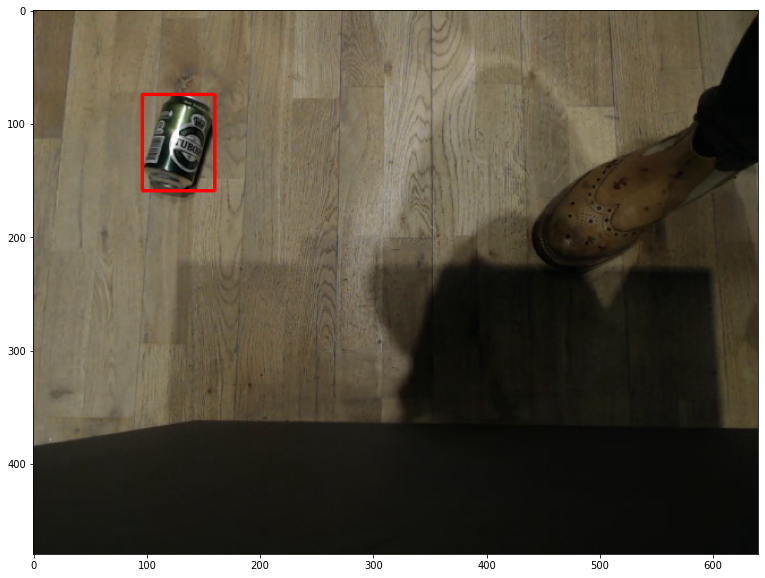

In [7]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
dataset = canDataset('../project_20_data/project_20_data/')
color = (255,0,0)
x = dataset[5]
img = (np.array(x[0]))

x1 = (x[1]['boxes'][0][0].item())
y1 = (x[1]['boxes'][0][1].item())
x2 = (x[1]['boxes'][0][2].item())
y2 = (x[1]['boxes'][0][3].item())

cv2.rectangle(img, (int(x1),int(y1)), (int(x2), int(y2)), color, 2)
plt.figure(figsize = (200,10))
plt.imshow(img)
#x[0]

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining the model
In order to obtain fast inference and reasonable training time, we chose to use the pretrained model of mobilenet_v2

In [8]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    
    # load a pre-trained model for classification and return
    # only the features
    backbone = torchvision.models.mobilenet_v2(pretrained=True).features
    #backbone = torchvision.models.mobilenet_v3_small(pretrained=True)
    # FasterRCNN needs to know the number of
    # output channels in a backbone. For mobilenet_v2, it's 1280
    # so we need to add it here
    backbone.out_channels = 1280

    # let's make the RPN generate 5 x 3 anchors per spatial
    # location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature
    # map could potentially have different sizes and
    # aspect ratios 
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))

    # let's define what are the feature maps that we will
    # use to perform the region of interest cropping, as well as
    # the size of the crop after rescaling.
    # if your backbone returns a Tensor, featmap_names is expected to
    # be [0]. More generally, the backbone should return an
    # OrderedDict[Tensor], and in featmap_names you can choose which
    # feature maps to use.
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)

    # put the pieces together inside a FasterRCNN model
    model = FasterRCNN(backbone,
                       num_classes=3,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler)
    return model
    '''
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 3  # 1 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model
    '''

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook



Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [9]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Testing forward() method 

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.


In [10]:
'''
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#dataset = canDataset('project_20_data/project_20_data/videoBoth', get_transform(train=True))
dataset = canDataset('project_20_data/project_20_data/videoBoth', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn
)
# For Training

images,targets = next(iter(data_loader))
#print("test1")

images = list(image for image in images)
#print(np.size(images),1)
#print(len(images))
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions
'''


'\nmodel = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)\n#dataset = canDataset(\'project_20_data/project_20_data/videoBoth\', get_transform(train=True))\ndataset = canDataset(\'project_20_data/project_20_data/videoBoth\', get_transform(train=True))\ndata_loader = torch.utils.data.DataLoader(\n    dataset, batch_size=2, shuffle=True, num_workers=2,\n    collate_fn=utils.collate_fn\n)\n# For Training\n\nimages,targets = next(iter(data_loader))\n#print("test1")\n\nimages = list(image for image in images)\n#print(np.size(images),1)\n#print(len(images))\ntargets = [{k: v for k, v in t.items()} for t in targets]\noutput = model(images,targets)   # Returns losses and detections\n# For inference\nmodel.eval()\nx = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]\npredictions = model(x)           # Returns predictions\n'

In [11]:
#print(predictions)

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them. We do a split of 80% training and 20% test as it seems to be the standard way of doing it. 

In [13]:
# use our dataset and defined transformations
#dataset = canDataset('project_20_data/project_20_data/videoBoth', get_transform(train=True))
#dataset_test = canDataset('project_20_data/project_20_data/videoBoth', get_transform(train=False))

dataset = canDataset('../project_20_data/project_20_data/', get_transform(train=True))
dataset_test = canDataset('../project_20_data/project_20_data/', get_transform(train=False))

# split the dataset in train and test set 80-20
torch.manual_seed(42)
#indices = torch.randperm(len(dataset)).tolist()
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
dataset, dataset_test = torch.utils.data.random_split(dataset, [train_size, test_size])
print("size of training dataset",len(dataset))
print("size of test datasest", len(dataset_test))
print(dataset_test[0])
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)


size of training dataset 1741
size of test datasest 436
(tensor([[[0.2627, 0.2588, 0.2784,  ..., 0.3686, 0.3843, 0.3765],
         [0.2784, 0.2314, 0.2314,  ..., 0.3686, 0.3843, 0.3765],
         [0.2824, 0.2275, 0.2235,  ..., 0.3647, 0.3765, 0.3686],
         ...,
         [0.0784, 0.0784, 0.0784,  ..., 0.0745, 0.0745, 0.0745],
         [0.0824, 0.0824, 0.0824,  ..., 0.0745, 0.0745, 0.0745],
         [0.0824, 0.0824, 0.0824,  ..., 0.0745, 0.0745, 0.0745]],

        [[0.2196, 0.2157, 0.2392,  ..., 0.3255, 0.3412, 0.3333],
         [0.2353, 0.1882, 0.1922,  ..., 0.3255, 0.3412, 0.3333],
         [0.2275, 0.1725, 0.1725,  ..., 0.3176, 0.3333, 0.3255],
         ...,
         [0.0784, 0.0784, 0.0784,  ..., 0.0745, 0.0745, 0.0745],
         [0.0824, 0.0824, 0.0824,  ..., 0.0745, 0.0745, 0.0745],
         [0.0824, 0.0824, 0.0824,  ..., 0.0745, 0.0745, 0.0745]],

        [[0.1569, 0.1529, 0.1569,  ..., 0.2000, 0.2157, 0.2078],
         [0.1725, 0.1255, 0.1098,  ..., 0.2000, 0.2157, 0.2078],
 

Now let's instantiate the model and the optimizer, note that here the adam algorithm is used over SGD.

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 3 classes - background and beer and cola
num_classes = 3

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005,
#                            momentum=0.9, weight_decay=0.0005)

#optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [9]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 15
val_loss_list2 = []
epoch_list2 = []
metric_collector2 = []

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    metric_logger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    metric_collector2.append(metric_logger)

    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    val_loss = evaluate(model, data_loader_test, device=device)
    epoch_list2.append(epoch)
    val_loss_list2.append(val_loss)
    

    #fig = plt.figure()
    #ax = plt.axes()
    
    #ax.plot(epoch_list, val_loss_list)
    #ax.set_title("Validation Scores")
    #ax.set_xlabel("Epochs")
    #ax.set_ylabel("Score")
    #plt.show()
    #print(val_loss.item())
    if(epoch > 8):
        torch.save(model.state_dict(), os.path.join("project_20_data/", 'epoch2-{}.pt'.format(epoch)))



Epoch: [0]  [  0/156]  eta: 0:02:17  lr: 0.000037  loss: 1.8605 (1.8605)  loss_classifier: 1.1063 (1.1063)  loss_box_reg: 0.0398 (0.0398)  loss_objectness: 0.6866 (0.6866)  loss_rpn_box_reg: 0.0277 (0.0277)  time: 0.8829  data: 0.1205  max mem: 2890
Epoch: [0]  [ 10/156]  eta: 0:01:18  lr: 0.000359  loss: 1.6624 (1.5881)  loss_classifier: 0.9262 (0.8487)  loss_box_reg: 0.0211 (0.0258)  loss_objectness: 0.6866 (0.6844)  loss_rpn_box_reg: 0.0277 (0.0292)  time: 0.5370  data: 0.0149  max mem: 3518
Epoch: [0]  [ 20/156]  eta: 0:01:10  lr: 0.000682  loss: 1.0435 (1.2230)  loss_classifier: 0.3420 (0.5465)  loss_box_reg: 0.0245 (0.0279)  loss_objectness: 0.6343 (0.6243)  loss_rpn_box_reg: 0.0210 (0.0243)  time: 0.5009  data: 0.0043  max mem: 3518
Epoch: [0]  [ 30/156]  eta: 0:01:04  lr: 0.001004  loss: 0.6631 (1.0169)  loss_classifier: 0.1820 (0.4311)  loss_box_reg: 0.0320 (0.0301)  loss_objectness: 0.4330 (0.5355)  loss_rpn_box_reg: 0.0138 (0.0202)  time: 0.4984  data: 0.0041  max mem: 3518


Epoch: [1]  [100/156]  eta: 0:00:28  lr: 0.005000  loss: 0.1305 (0.1691)  loss_classifier: 0.0397 (0.0499)  loss_box_reg: 0.0781 (0.1048)  loss_objectness: 0.0071 (0.0097)  loss_rpn_box_reg: 0.0038 (0.0047)  time: 0.4984  data: 0.0041  max mem: 3518
Epoch: [1]  [110/156]  eta: 0:00:23  lr: 0.005000  loss: 0.1265 (0.1645)  loss_classifier: 0.0467 (0.0492)  loss_box_reg: 0.0729 (0.1012)  loss_objectness: 0.0071 (0.0096)  loss_rpn_box_reg: 0.0033 (0.0046)  time: 0.4984  data: 0.0041  max mem: 3518
Epoch: [1]  [120/156]  eta: 0:00:18  lr: 0.005000  loss: 0.1173 (0.1611)  loss_classifier: 0.0418 (0.0484)  loss_box_reg: 0.0599 (0.0988)  loss_objectness: 0.0063 (0.0093)  loss_rpn_box_reg: 0.0036 (0.0046)  time: 0.4987  data: 0.0041  max mem: 3518
Epoch: [1]  [130/156]  eta: 0:00:13  lr: 0.005000  loss: 0.1152 (0.1569)  loss_classifier: 0.0362 (0.0473)  loss_box_reg: 0.0676 (0.0961)  loss_objectness: 0.0058 (0.0090)  loss_rpn_box_reg: 0.0035 (0.0045)  time: 0.4996  data: 0.0041  max mem: 3518


Epoch: [3]  [  0/156]  eta: 0:01:35  lr: 0.000500  loss: 0.0474 (0.0474)  loss_classifier: 0.0186 (0.0186)  loss_box_reg: 0.0230 (0.0230)  loss_objectness: 0.0031 (0.0031)  loss_rpn_box_reg: 0.0028 (0.0028)  time: 0.6116  data: 0.1130  max mem: 3518
Epoch: [3]  [ 10/156]  eta: 0:01:14  lr: 0.000500  loss: 0.0580 (0.0619)  loss_classifier: 0.0228 (0.0216)  loss_box_reg: 0.0311 (0.0352)  loss_objectness: 0.0027 (0.0030)  loss_rpn_box_reg: 0.0017 (0.0020)  time: 0.5099  data: 0.0141  max mem: 3518
Epoch: [3]  [ 20/156]  eta: 0:01:09  lr: 0.000500  loss: 0.0580 (0.0619)  loss_classifier: 0.0173 (0.0207)  loss_box_reg: 0.0347 (0.0364)  loss_objectness: 0.0027 (0.0031)  loss_rpn_box_reg: 0.0014 (0.0018)  time: 0.5023  data: 0.0042  max mem: 3518
Epoch: [3]  [ 30/156]  eta: 0:01:04  lr: 0.000500  loss: 0.0511 (0.0606)  loss_classifier: 0.0180 (0.0215)  loss_box_reg: 0.0306 (0.0343)  loss_objectness: 0.0028 (0.0031)  loss_rpn_box_reg: 0.0012 (0.0016)  time: 0.5120  data: 0.0054  max mem: 3518


Epoch: [4]  [100/156]  eta: 0:00:28  lr: 0.000500  loss: 0.0541 (0.0515)  loss_classifier: 0.0182 (0.0204)  loss_box_reg: 0.0282 (0.0272)  loss_objectness: 0.0025 (0.0029)  loss_rpn_box_reg: 0.0008 (0.0010)  time: 0.5073  data: 0.0043  max mem: 3518
Epoch: [4]  [110/156]  eta: 0:00:23  lr: 0.000500  loss: 0.0444 (0.0509)  loss_classifier: 0.0183 (0.0204)  loss_box_reg: 0.0229 (0.0267)  loss_objectness: 0.0022 (0.0028)  loss_rpn_box_reg: 0.0006 (0.0010)  time: 0.5035  data: 0.0043  max mem: 3518
Epoch: [4]  [120/156]  eta: 0:00:18  lr: 0.000500  loss: 0.0422 (0.0503)  loss_classifier: 0.0179 (0.0201)  loss_box_reg: 0.0203 (0.0263)  loss_objectness: 0.0020 (0.0030)  loss_rpn_box_reg: 0.0006 (0.0010)  time: 0.5064  data: 0.0043  max mem: 3518
Epoch: [4]  [130/156]  eta: 0:00:13  lr: 0.000500  loss: 0.0379 (0.0499)  loss_classifier: 0.0130 (0.0199)  loss_box_reg: 0.0182 (0.0261)  loss_objectness: 0.0019 (0.0029)  loss_rpn_box_reg: 0.0007 (0.0010)  time: 0.5061  data: 0.0043  max mem: 3518


Epoch: [6]  [  0/156]  eta: 0:01:36  lr: 0.000050  loss: 0.0247 (0.0247)  loss_classifier: 0.0117 (0.0117)  loss_box_reg: 0.0106 (0.0106)  loss_objectness: 0.0022 (0.0022)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.6213  data: 0.1142  max mem: 3518
Epoch: [6]  [ 10/156]  eta: 0:01:15  lr: 0.000050  loss: 0.0444 (0.0495)  loss_classifier: 0.0161 (0.0206)  loss_box_reg: 0.0291 (0.0257)  loss_objectness: 0.0023 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0009)  time: 0.5204  data: 0.0144  max mem: 3518
Epoch: [6]  [ 20/156]  eta: 0:01:09  lr: 0.000050  loss: 0.0474 (0.0530)  loss_classifier: 0.0161 (0.0212)  loss_box_reg: 0.0295 (0.0280)  loss_objectness: 0.0023 (0.0026)  loss_rpn_box_reg: 0.0007 (0.0011)  time: 0.5076  data: 0.0044  max mem: 3518
Epoch: [6]  [ 30/156]  eta: 0:01:04  lr: 0.000050  loss: 0.0355 (0.0478)  loss_classifier: 0.0129 (0.0189)  loss_box_reg: 0.0176 (0.0255)  loss_objectness: 0.0022 (0.0024)  loss_rpn_box_reg: 0.0008 (0.0010)  time: 0.5038  data: 0.0043  max mem: 3518


Epoch: [7]  [100/156]  eta: 0:00:29  lr: 0.000050  loss: 0.0338 (0.0454)  loss_classifier: 0.0138 (0.0186)  loss_box_reg: 0.0169 (0.0232)  loss_objectness: 0.0022 (0.0027)  loss_rpn_box_reg: 0.0005 (0.0009)  time: 0.5193  data: 0.0044  max mem: 3518
Epoch: [7]  [110/156]  eta: 0:00:24  lr: 0.000050  loss: 0.0419 (0.0452)  loss_classifier: 0.0175 (0.0187)  loss_box_reg: 0.0162 (0.0230)  loss_objectness: 0.0018 (0.0026)  loss_rpn_box_reg: 0.0006 (0.0008)  time: 0.5202  data: 0.0045  max mem: 3518
Epoch: [7]  [120/156]  eta: 0:00:18  lr: 0.000050  loss: 0.0472 (0.0460)  loss_classifier: 0.0181 (0.0194)  loss_box_reg: 0.0147 (0.0231)  loss_objectness: 0.0019 (0.0027)  loss_rpn_box_reg: 0.0006 (0.0008)  time: 0.5206  data: 0.0045  max mem: 3518
Epoch: [7]  [130/156]  eta: 0:00:13  lr: 0.000050  loss: 0.0403 (0.0455)  loss_classifier: 0.0179 (0.0191)  loss_box_reg: 0.0134 (0.0228)  loss_objectness: 0.0018 (0.0028)  loss_rpn_box_reg: 0.0006 (0.0008)  time: 0.5193  data: 0.0044  max mem: 3518


Epoch: [9]  [  0/156]  eta: 0:01:39  lr: 0.000005  loss: 0.0765 (0.0765)  loss_classifier: 0.0307 (0.0307)  loss_box_reg: 0.0410 (0.0410)  loss_objectness: 0.0032 (0.0032)  loss_rpn_box_reg: 0.0017 (0.0017)  time: 0.6392  data: 0.1235  max mem: 3518
Epoch: [9]  [ 10/156]  eta: 0:01:16  lr: 0.000005  loss: 0.0443 (0.0548)  loss_classifier: 0.0173 (0.0230)  loss_box_reg: 0.0247 (0.0269)  loss_objectness: 0.0030 (0.0039)  loss_rpn_box_reg: 0.0006 (0.0011)  time: 0.5206  data: 0.0152  max mem: 3518
Epoch: [9]  [ 20/156]  eta: 0:01:09  lr: 0.000005  loss: 0.0443 (0.0528)  loss_classifier: 0.0166 (0.0205)  loss_box_reg: 0.0247 (0.0280)  loss_objectness: 0.0023 (0.0031)  loss_rpn_box_reg: 0.0006 (0.0012)  time: 0.5062  data: 0.0043  max mem: 3518
Epoch: [9]  [ 30/156]  eta: 0:01:04  lr: 0.000005  loss: 0.0354 (0.0465)  loss_classifier: 0.0160 (0.0188)  loss_box_reg: 0.0169 (0.0238)  loss_objectness: 0.0018 (0.0028)  loss_rpn_box_reg: 0.0006 (0.0010)  time: 0.5053  data: 0.0043  max mem: 3518


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "project_20_data/mobilenet_bigModel_bothVideo3.pth")


Now that training has finished, let's have a look at what it actually predicts in a test image

In [16]:
import torchvision.transforms as T
from torchvision.io import read_image
from pathlib import Path
from torchvision import transforms
img_transforms = T.Compose([T.ToPILImage(),T.ToTensor()])
# pick one image from the test set

# put the model in evaluation mode
img_idx = 60

img = read_image(str(Path("../project_20_data/project_20_data/frames_video2/")) + "/frame_"+ str(img_idx).zfill(6) +".PNG")

img = Image.open(str(Path("../project_20_data/project_20_data/frames_video2/")) + "/frame_"+ str(img_idx).zfill(6) +".PNG").convert("RGB")
img.resize((128, 96))
trans1 = transforms.ToTensor()
img=trans1(img)

#img = Image.open(str(Path("project_20_data/project_20_data/frames_video1_continued/")) + "/frame_"+ str(image_id[0]+60).zfill(6) +".PNG")
img = img_transforms(img)
print(img)
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

tensor([[[0.3451, 0.3412, 0.3529,  ..., 0.2980, 0.3020, 0.3176],
         [0.3647, 0.3333, 0.3098,  ..., 0.2980, 0.3020, 0.3137],
         [0.3686, 0.3294, 0.2980,  ..., 0.2980, 0.3020, 0.3098],
         ...,
         [0.0824, 0.0824, 0.0824,  ..., 0.0588, 0.0627, 0.0627],
         [0.0863, 0.0863, 0.0863,  ..., 0.0588, 0.0627, 0.0627],
         [0.0863, 0.0863, 0.0863,  ..., 0.0588, 0.0627, 0.0627]],

        [[0.2941, 0.2902, 0.3020,  ..., 0.2627, 0.2667, 0.2824],
         [0.3137, 0.2824, 0.2588,  ..., 0.2627, 0.2667, 0.2784],
         [0.3176, 0.2784, 0.2471,  ..., 0.2588, 0.2627, 0.2706],
         ...,
         [0.0824, 0.0824, 0.0824,  ..., 0.0588, 0.0627, 0.0627],
         [0.0863, 0.0863, 0.0863,  ..., 0.0588, 0.0627, 0.0627],
         [0.0863, 0.0863, 0.0863,  ..., 0.0588, 0.0627, 0.0627]],

        [[0.2157, 0.2118, 0.2157,  ..., 0.1725, 0.1725, 0.1882],
         [0.2353, 0.2039, 0.1725,  ..., 0.1725, 0.1725, 0.1843],
         [0.2314, 0.1922, 0.1569,  ..., 0.1686, 0.1686, 0.

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [17]:
prediction

[{'boxes': tensor([[4.4796e+02, 3.1530e+02, 4.6096e+02, 3.2488e+02],
          [4.4848e+02, 3.3124e+02, 4.6138e+02, 3.4586e+02],
          [4.5136e+02, 3.1280e+02, 4.7434e+02, 3.6197e+02],
          [4.4862e+02, 3.2953e+02, 4.7026e+02, 3.6443e+02],
          [4.4667e+02, 3.1145e+02, 4.8714e+02, 3.3562e+02],
          [4.3593e+02, 3.4367e+02, 4.9415e+02, 3.6316e+02],
          [4.6763e+02, 3.2780e+02, 4.9009e+02, 3.6142e+02],
          [4.4741e+02, 2.9702e+02, 4.7643e+02, 3.4872e+02],
          [4.2922e+02, 3.1350e+02, 4.5332e+02, 3.5890e+02],
          [4.5005e+02, 3.0255e+02, 4.6990e+02, 3.3288e+02],
          [4.3394e+02, 3.1631e+02, 4.4809e+02, 3.2513e+02],
          [4.6971e+02, 3.2787e+02, 4.8148e+02, 3.4346e+02],
          [4.3363e+02, 3.3385e+02, 4.4718e+02, 3.4605e+02],
          [4.2459e+02, 3.4177e+02, 4.6465e+02, 3.6713e+02],
          [4.7291e+02, 3.1386e+02, 4.9463e+02, 3.5443e+02],
          [4.5751e+02, 3.5242e+02, 4.7612e+02, 3.6410e+02],
          [4.7285e+02, 3.1362e+

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

[0.4524196684360504, 0.45226141810417175, 0.44988515973091125, 0.44930264353752136, 0.44519221782684326, 0.43906962871551514, 0.43372195959091187, 0.4335487484931946, 0.43230414390563965, 0.4322507083415985, 0.4320638179779053, 0.43067696690559387, 0.4292464852333069, 0.42773810029029846, 0.42725592851638794, 0.4257960021495819, 0.4255724847316742, 0.42495372891426086, 0.4246126413345337, 0.42335131764411926, 0.42295825481414795, 0.421090304851532, 0.4204215407371521, 0.4203266203403473, 0.4191060960292816, 0.418499231338501, 0.4177672564983368, 0.41712695360183716, 0.41664329171180725, 0.4161951541900635, 0.4158816933631897, 0.4158560335636139, 0.41556835174560547, 0.41468530893325806, 0.4143639802932739, 0.41383370757102966, 0.4137791693210602, 0.4124499261379242, 0.4123859405517578, 0.4116366505622864, 0.4100666642189026, 0.4096093475818634, 0.40896227955818176, 0.4088832437992096, 0.40877124667167664, 0.4076639413833618, 0.40719524025917053, 0.4063641130924225, 0.4061492383480072, 

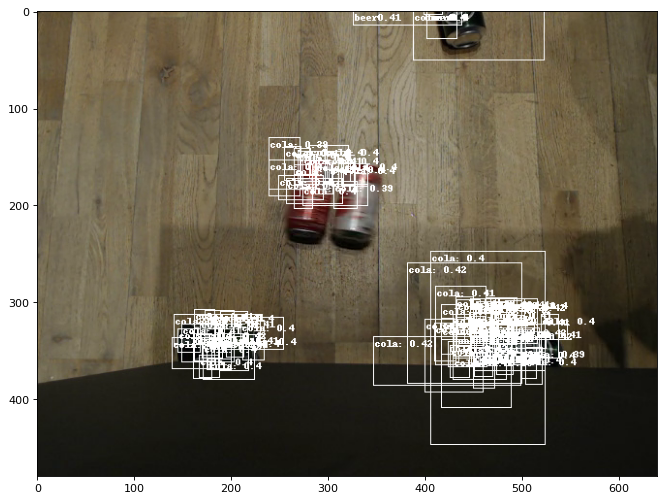

In [19]:
#Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
from pathlib import Path
import cv2
#import matplotlib.pyplot as plt
import torch
import numpy as np

import torchvision.transforms.functional as F


#plt.rcParams["savefig.bbox"] = 'tight'

boxes = torch.as_tensor(prediction[0]['boxes'].cpu().numpy(), dtype=torch.float)
labels_int = (prediction[0]['labels'].cpu().numpy()).tolist()
scores = (prediction[0]['scores'].cpu().numpy()).tolist()
print(scores)
labels_str = []
i=0
for i,label in enumerate(labels_int):
    if(label==1):
        labels_str.append("cola: "+str(round(scores[i],2)))
    else:
        labels_str.append("beer"+str(round(scores[i],2)))
    print(i)

def show(img):
    plt.figure(figsize=(10, 10), dpi=80)
    img = img.detach()
    img = F.to_pil_image(img)
    plt.imshow(np.asarray(img))
    



#img_path = os.path.join( "project_20_data/project_20_data/frames_video1_continued/", "frame_"+str(1).zfill(6)+".PNG")
img = read_image(str(Path("../project_20_data/project_20_data/frames_video2/")) + "/frame_"+ str(img_idx).zfill(6) +".PNG")

#img, _ = dataset_test[0]
img = img.type(torch.uint8)

drawn_boxes = draw_bounding_boxes(img, boxes,labels_str)

#open_cv_image = np.array(img) 
#img = Image.fromarray(open_cv_image, 'RGB')

show(drawn_boxes)
#torch.save(model.state_dict(), "project_20_data/mobilenet_bigModel.pth")


And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

In [ ]:
import torchvision.transforms as T
from torchvision.io import read_image
from pathlib import Path
img_transforms = T.Compose([T.ToPILImage(),T.ToTensor()])
import torch
# pick one image from the test set
# put the model in evaluation mode
img_idx = 60
num_classes =3
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model2 = get_instance_segmentation_model(num_classes)
model2.load_state_dict(torch.load("/home/alexander/Documents/DTU/Deep learning/project_20_data/mobilenet_bigModel.pth"))


#img = read_image(str(Path("project_20_data/project_20_data/frames_video2/")) + "/frame_"+ str(img_idx).zfill(6) +".PNG")
img = read_image(str(Path("project_20_data/project_20_data/")) +"/tuborg.jpg")

#img = Image.open(str(Path("project_20_data/project_20_data/frames_video1_continued/")) + "/frame_"+ str(image_id[0]+60).zfill(6) +".PNG")
img = img_transforms(img)
model2.to(device)
model2.eval()
with torch.no_grad():
    prediction = model2([img.to(device)])
    
prediction

Looks pretty good!

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.8.2/references/detection). 

